# Dependencies and helper functions

In [ ]:
%%capture
!pip install transformers

In [ ]:
import pandas as pd

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Data Pre-processing
In this section, we load the data required for training the model and perform any appropriate filtering/pre-processing

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

ROOT        = 'gdrive/Shared drives/CDT Mini-Project Team 1/Colab Notebooks/'
DATA_DIR    = ROOT + 'data/' 
MODELS_DIR  = ROOT + 'models/'

Mounted at /content/gdrive


In [ ]:
#Load all data
qaps = pd.read_csv(DATA_DIR + 'narrativeqa_qaps_single_answer.csv')

# Remove data where the answer is not an exact span of the text (for training and validation purposes)
qaps = qaps[qaps['ans_start']!=-1]

In [ ]:
qaps[qaps['set']=='train'].head()

,Unnamed: 0,set,question_tokenized,summary,answer,ans_start
30,30,train,Who does Arabella Mason wed ?,"At Madeline Hall , an old mansion-house near S...",Ben Keene,432
39,39,train,What is the name of the de Versely family house ?,"At Madeline Hall , an old mansion-house near S...",Madeline Hall,3
40,40,train,Who lives at Madeline Hall ?,"At Madeline Hall , an old mansion-house near S...",Miss Delmar,128
41,41,train,Who does Capitan Delmar suggest Ben marry in s...,"At Madeline Hall , an old mansion-house near S...",Arabella,215
42,42,train,Who is Ben and Arabella s son ?,"At Madeline Hall , an old mansion-house near S...",Percival Keene,902


Acquire data in lists of: contexts (summaries), questions, answers

In [ ]:
def format_data(data):
  contexts = []
  questions = []
  answers = []
  for index, row in data.iterrows():
    context   = row['summary']
    question  = row['question_tokenized']
    answer    = {}
    answer['text'] = row['answer']
    answer['answer_start'] = row['ans_start']

    contexts.append(context)
    questions.append(question)
    answers.append(answer)
  
  return contexts, questions, answers

train_contexts, train_questions, train_answers  = format_data(qaps[qaps['set']=='train'])
val_contexts, val_questions, val_answers        = format_data(qaps[qaps['set']=='valid'])

Calculate end positions of answers as they appear in the summaries

In [ ]:
def add_end_idx(answers, contexts):
    for answer, context in zip(answers, contexts):
        gold_text = answer['text'].strip()
        answer['text'] = gold_text
        start_idx = answer['answer_start']
        end_idx   = start_idx + len(gold_text) - 1
        answer['answer_end'] = end_idx

add_end_idx(train_answers, train_contexts)
add_end_idx(val_answers, val_contexts)

# Model information / hyperparameter selection
In this section we have details on our model type, and the start-points for training (either a pre-trained model or a partially trained model we wish to resume training)

To keep our experiments valid - ensure that the model id is of the form "modelname-learning-rate". 

If you resume training for a model, ensure the learning rates are consistent

In [ ]:
from transformers import BertForQuestionAnswering, BertTokenizerFast, DistilBertTokenizerFast, DistilBertForQuestionAnswering, AutoModelForQuestionAnswering, AutoTokenizer
import pickle
import os

MODEL_IDS = ['distilbert-base-uncased-distilled-squad',
             'distilbert-base-cased-distilled-squad',
             'bert-large-uncased-whole-word-masking-finetuned-squad',
             'mrm8488/longformer-base-4096-finetuned-squadv2',
             'distilbert-squad-nqa-5e-5',
             'distilbert-squad-nqa-3e-5',
             'bert-large-squad-nqa-3e-5'
             'bert-large-squad-nqa-5e-5',
             'bert-large-squad-nqa-5e-6',
             'Primer/bart-squad2']

model_types = ['distilbert', 'bert-base', 'bert-large', 'longformer']

# select model id
MODEL_ID      = MODEL_IDS[3]
model_type    = model_types[3]
finetuned     = True         # is the model saved on Drive
epoch_to_load = 2            # if a model uploaded to Drive, which epoch to load

batch_sizes = {'distilbert': 32, 'bert-base': 32, 'bert-large': 4, 'longformer': 2}

In [ ]:
#set hyperparameters (make sure they match the MODEL_ID above)

num_of_epochs = 4     #recommended between 2-4
lr            = 3e-5  #learning rate (recommended 2e-5, 3e-5, 5e-5)

In [ ]:
#If we are training from scratch then load up the appropriate model, else load the partially trained model
if finetuned:
  MODEL_PATH = MODELS_DIR + MODEL_ID
  MODEL_PATH = MODEL_PATH + '/epoch' + str(epoch_to_load)
  with open(MODEL_PATH + '/stats', "rb") as stats:
    training_stats = pickle.load(stats)
  print('Training {} (finetuned for {} epochs)'.format(MODEL_ID, str(epoch_to_load)))
  current_epoch = epoch_to_load

else:
  MODEL_PATH = MODEL_ID
  print('Training {}'.format(MODEL_ID))
  current_epoch = 0
  training_stats = []

# load tokenizer and model 

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model     = AutoModelForQuestionAnswering.from_pretrained(MODEL_PATH,
                                                          output_attentions = False,
                                                          output_hidden_states=False)

batch_size = batch_sizes[model_type]

Training mrm8488/longformer-base-4096-finetuned-squadv2 (finetuned for 2 epochs)


# Data tokenization
In this section we format our data so it is of the form required for GPU training.

Additional features are (likely to be) added here.

In [ ]:
dummy_questions = ['How big is the Empire State Building?', 'Who is Shrek married to?']
dummy_contexts = ['The Empire State building is a very big building. It is one of the biggest buildings in the world. It is large.', 'Shrek is an ogre. There is a common misconception that Shrek is married to Fiona, but he is actually married to Donkey.']
dummy_answers = [{'text': 'very big', 'answer_start': 31, 'answer_end': 38}, {'text': 'Donkey', 'answer_start': 112, 'answer_end': 117}]

In [ ]:
def tokenize_questions_and_contexts(questions, contexts, tokenizer):

  input_ids       = []
  token_type_ids  = []

  for i in range(len(questions)):
    question_input_ids      = tokenizer.encode(question, context, truncation='only_second',padding='max_length')
    sep_index               = question_input_ids.index(tokenizer.sep_token_id)
    num_tokens_question     = sep_index + 1
    num_tokens_context      = len(q_input_ids) - num_tokens_question
    question_token_type_ids = [0]*num_tokens_question + [1]*num_tokens_context

    input_ids.append(torch.tensor(q_input_ids))
    token_type_ids.append(torch.tensor(question_token_type_ids))
    tokens.append(tokenizer.convert_ids_to_tokens(question_input_ids))

  input_ids       = torch.cat(input_ids, dim=0)
  token_type_ids  = torch.cat(token_type_ids, dim=0)

  return input_ids, token_type_ids

#dummy_encodings = tokenizer(dummy_questions, dummy_contexts, truncation='only_second',padding='max_length')
train_encodings = tokenizer(train_questions, train_contexts, truncation='only_second', padding='longest')
val_encodings = tokenizer(val_questions, val_contexts, truncation='only_second', padding='longest')

In [ ]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions   = []

    for i in range(len(answers)):
      char_to_token_start = encodings.char_to_token(i, answers[i]['answer_start'], sequence_index=1)
      char_to_token_end = encodings.char_to_token(i, answers[i]['answer_end'], sequence_index=1)
      
      input_ids = encodings.input_ids[i]
      tokens = tokenizer.decode(encodings.input_ids[i])
      # print('input ids:', input_ids[:64])
      # print('tokens:', tokens[:256])
      #print('answer info:', answers[i])
      #print('char_to_token start:', char_to_token_start)
      #print('char_to_token end:', char_to_token_end)
      #print('decoded start token:', tokenizer.decode(input_ids[char_to_token_start]))
      #print('decoded end token:', tokenizer.decode(input_ids[char_to_token_end]))
      # print('')

      start_positions.append(char_to_token_start)
      end_positions.append(char_to_token_end)

      # if start position is None, the answer passage has been truncated
      if start_positions[-1] is None:
          start_positions[-1] = tokenizer.model_max_length

      # if end position is None, the 'char_to_token' function points to the space before the correct token - > add + 1
      if end_positions[-1] is None:
        end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] + 1)

      if end_positions[-1] is None:
        end_positions[-1] = tokenizer.model_max_length

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

#add_token_positions(dummy_encodings, dummy_answers)
add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

In [ ]:
import torch

class NQADataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

dummy_dataset = NQADataset(dummy_encodings)
train_dataset = NQADataset(train_encodings)
val_dataset = NQADataset(val_encodings)

## Training

In [ ]:
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW

# create DataLoaders
train_loader = DataLoader(train_dataset,
                          sampler = RandomSampler(train_dataset),
                          batch_size=batch_size)

# For dev the order doesn't matter, so we'll just read them sequentially.
val_loader = DataLoader(
            val_dataset, # The dev samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# initialise optimizer
optim = AdamW(model.parameters(), 
              lr=lr,
              eps = 1e-8)

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_loader) * (num_of_epochs - current_epoch)

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optim, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.cuda()
model.to(device)

# Measure how long the training epoch takes.
total_t0 = time.time()

for epoch in range(current_epoch, num_of_epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, num_of_epochs))
    print('Training...')  

    # Measure how long training epoch takes
    t0 = time.time()

    # Reset loss for epoch
    total_train_loss = 0
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_loader):

        # Progress update every 40 batches.
        if (step % 40 == 0 or step < 6) and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_loader), elapsed))

        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs.loss

        # accumulate training loss over batches
        total_train_loss += loss.item()

        # clip norm of gradients to 1.0 to address vanishing gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        loss.backward()
        optim.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_loader)
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))



    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running validation...")

    total_val_loss = 0
    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Evaluate data for one epoch
    for batch in val_loader:

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        # Don't construct a compute graph (only required for backprop during training)
        with torch.no_grad():
          outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)

        loss = outputs.loss
        total_val_loss += loss.item()

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_val_loss / len(val_loader)

    # Measure how long the dev run took.
    dev_time = format_time(time.time() - t0)
    
    print("  Dev Loss: {0:.2f}".format(avg_val_loss))
    print("  Dev took: {:}".format(dev_time))

    training_stats.append(
        {
            'epoch': epoch + 1,
            'training_loss': avg_train_loss,
            'validation_loss': avg_val_loss,
            'total_loss': avg_train_loss + avg_val_loss
        }
    )

    print("")
    print("Saving model")

    # Save a trained model, configuration and tokenizer using `save_pretrained()`.
    # They can then be reloaded using `from_pretrained()`
    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training

    MODEL_PATH = MODELS_DIR + MODEL_ID + '/epoch' + str(epoch + 1)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    model_to_save.save_pretrained(MODEL_PATH)
    tokenizer.save_pretrained(MODEL_PATH)
    with open(MODEL_PATH + '/stats', "wb") as stats:
      pickle.dump(training_stats, stats)

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 3 / 4 ========
Training...


/usr/local/lib/python3.6/dist-packages/transformers/models/longformer/modeling_longformer.py:398: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  sep_token_indices = (input_ids == sep_token_id).nonzero()


  Batch     1  of  7,146.    Elapsed: 0:00:01.
  Batch     2  of  7,146.    Elapsed: 0:00:02.
  Batch     3  of  7,146.    Elapsed: 0:00:03.
  Batch     4  of  7,146.    Elapsed: 0:00:04.
  Batch     5  of  7,146.    Elapsed: 0:00:05.
  Batch    40  of  7,146.    Elapsed: 0:00:35.
  Batch    80  of  7,146.    Elapsed: 0:01:09.
  Batch   120  of  7,146.    Elapsed: 0:01:43.
  Batch   160  of  7,146.    Elapsed: 0:02:17.
  Batch   200  of  7,146.    Elapsed: 0:02:52.
  Batch   240  of  7,146.    Elapsed: 0:03:26.
  Batch   280  of  7,146.    Elapsed: 0:04:00.
  Batch   320  of  7,146.    Elapsed: 0:04:35.
  Batch   360  of  7,146.    Elapsed: 0:05:09.
  Batch   400  of  7,146.    Elapsed: 0:05:43.
  Batch   440  of  7,146.    Elapsed: 0:06:18.
  Batch   480  of  7,146.    Elapsed: 0:06:52.
  Batch   520  of  7,146.    Elapsed: 0:07:26.
  Batch   560  of  7,146.    Elapsed: 0:08:00.
  Batch   600  of  7,146.    Elapsed: 0:08:35.
  Batch   640  of  7,146.    Elapsed: 0:09:09.
  Batch   680

# Model stats

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,training_loss,validation_loss,total_loss
epoch,,,
1,1.57,1.30,2.87
2,0.86,1.21,2.07
3,0.73,1.36,2.09
4,0.34,1.60,1.93


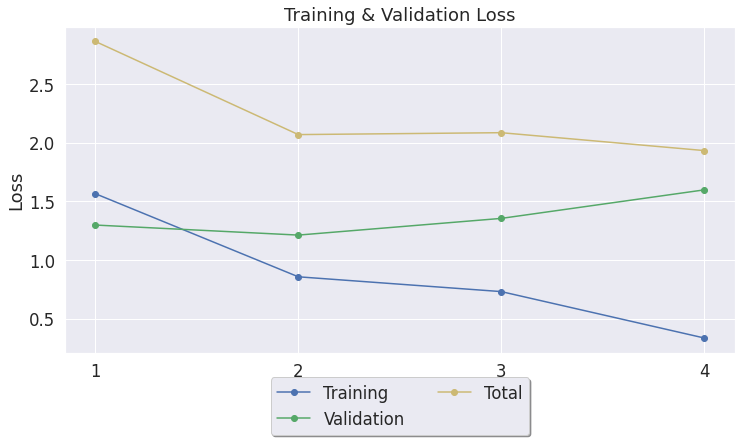

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['training_loss'], 'b-o', label="Training")
plt.plot(df_stats['validation_loss'], 'g-o', label="Validation")
plt.plot(df_stats['total_loss'], 'y-o', label="Total")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(1, num_of_epochs+1))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)


plt.show()

# Model Sandbox

In [ ]:
question = "Who is diana?"
text = " Anne, a young orphan from the fictional community of Bolingbroke, Nova Scotia (based upon the real community of New London), is sent to Prince Edward Island after a childhood spent in strangers' homes and orphanages. Marilla and Matthew Cuthbert, siblings in their fifties and sixties, had decided to adopt a boy from the orphanage to help Matthew run their farm. They live at Green Gables, their Avonlea farmhouse on Prince Edward Island. Through a misunderstanding, the orphanage sends Anne Shirley.\nAnne is described as bright and quick, eager to please, talkative, and extremely imaginative. She has a pale face with freckles and usually braids her red hair. Marilla at first says the girl must return to the orphanage, but after a few days, she decides to let her stay. Marilla feels that she could be a good influence on the girl and has also learned that a disagreeable woman in town might take Anne instead.\nAs a child of imagination, Anne takes much joy in life and adapts quickly, thriving in the close-knit farming village. Her talkativeness initially drives the prim, duty-driven Marilla to distraction, although Matthew falls for her charm immediately. Anne says that they are \"kindred spirits.\"\nThe book recounts Anne's adventures in making a home: the country school where she quickly excels in her studies; her friendship with Diana Barry (her best or \"bosom friend\" as Anne fondly calls her); her budding literary ambitions; and her rivalry with classmate Gilbert Blythe, who teases her about her red hair. For that, he earns her instant hatred, although he apologizes many times. As time passes, Anne realizes she no longer hates Gilbert but cannot bring herself to speak to him.\nThe book also follows Anne's adventures in quiet, old-fashioned Avonlea. Episodes include her play-time with friends (Diana, Jane Andrews and Ruby Gillis), her run-ins with the unpleasant Pye sisters (Gertie and Josie), and domestic mishaps such as dyeing her hair green (while intending to dye it black) or accidentally getting Diana drunk (by giving her what she thinks is raspberry cordial but is currant wine).\nAt fifteen, Anne goes to Queen's Academy to earn a teaching license, along with Gilbert, Ruby, Josie, Jane and several other students. She obtains her license in one year instead of the usual two and wins the Avery Scholarship for the top student in English. Her attainment of this scholarship would allow her to pursue a Bachelor of Arts (B.A.) degree at the fictional Redmond College (based on the real Dalhousie University) on the mainland in Nova Scotia.\nNear the end of the book, Matthew dies of a heart attack after learning that all of his and Marilla's money has been lost in a bank failure. Out of devotion to Marilla and Green Gables, Anne gives up the scholarship to stay at home and help Marilla, whose eyesight is failing. She plans to teach at the Carmody school, the nearest school available, and return to Green Gables on weekends. In an act of friendship, Gilbert Blythe gives up his teaching position at the Avonlea School to work at White Sands School instead, knowing that Anne wants to stay close to Marilla after Matthew's death. After this kind act, Anne and Gilbert's friendship is cemented, and Anne looks forward to the next \"bend in the road.\""

encodings = tokenizer(question, text, truncation='only_second', padding='max_length', return_tensors='pt')
inputs = encodings['input_ids'].to(device)
attention_mask = encodings['attention_mask'].to(device)

outputs = model(inputs)
start_scores = outputs.start_logits
end_scores = outputs.end_logits

tokens = [tokenizer.convert_ids_to_tokens(inputs.tolist()[0])]

In [ ]:
answer_starts = []
answer_ends = []
answers = []


answer_start = torch.argmax(start_scores)
answer_end = answer_start + torch.argmax(end_scores[0][answer_start:])
answer_starts.append(answer_start)
answer_ends.append(answer_end)

for source,answer_start,answer_end in zip(tokens, answer_starts,answer_ends):
  answer = tokenizer.decode(tokenizer.convert_tokens_to_ids(source[answer_start:answer_end+1]))
  answers.append(answer)

In [ ]:
print('Question:', question)
print('Answer:', answers[0])

Question: Who is diana?
Answer:  Diana
